# Constrained and concatenated analysis

For Figure 3e in Loback et al.

## Prepare workspace

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))

# Change path to match location of PPC datasets
# Datasets are available from the Harvey lab
import ppc_data_loader
ppc_data_loader.path = '/home/mrule/Workspace2/PPC_data/'

# Import PPC libraries
from ppc_data_loader   import *
from ppc_trial         import *

Data  location is /home/mrule/Workspace2/PPC_data/
Cache location is /home/mrule/Desktop/Github/Loback_et_al/Rule/cache
Loading nlab namespace


In [2]:
%matplotlib inline

from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE])
matplotlib.rcParams['figure.dpi']=150
figure() # Check that Matplotlib really did load (bug workaround?)

print('Matplotlib configured')

Matplotlib configured


<Figure size 900x600 with 0 Axes>

## Survey available data: identify longer streaches of consecutive days

In [3]:
consecutive_summary = {}
for animal in get_subject_ids():
    consecutive_summary[animal] = get_consecutive_recordings(animal,130,4)
    release_files(clear_cache=True)
    
print('I will check these spans of days:')
to_check = defaultdict(list)
for animal,spans in consecutive_summary.items():
    for (start,stop),units in spans.items():
        to_check[animal].append(list(arange(start,stop+1)))
to_check = dict(to_check)
for a,ss in to_check.items():
    print('  Mouse %d:'%a)
    for s in ss:
        print('    ',s)

Testing subject 1
  Available sessions 1 2 3 4 5 6 7 10 14 15 20 28 29 32 34 39 41 42 46 48 52
  There are 10 spans at least 4 days long; of these…
  There are 1 spans with at least 130 neurons:
  	04-07 (4 days, 186 neurons)
Testing subject 2
  Available sessions 1 2 3 4 5 10 15 20
  There are  3 spans at least 4 days long; of these…
  There are 0 spans with at least 130 neurons:
Testing subject 3
  Available sessions 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 30 35 42
  There are 210 spans at least 4 days long; of these…
  There are 9 spans with at least 130 neurons:
  	01-06 (6 days, 144 neurons)
  	02-07 (6 days, 132 neurons)
  	04-09 (6 days, 141 neurons)
  	05-10 (6 days, 142 neurons)
  	06-12 (7 days, 134 neurons)
  	09-14 (6 days, 134 neurons)
  	13-19 (7 days, 146 neurons)
  	14-20 (7 days, 130 neurons)
  	16-22 (7 days, 136 neurons)
Testing subject 4
  Available sessions 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 25
  There are 171 spans at l

# Constrained analysis subroutines

These are parallellized, since the multiple crossvalidations (and permutation samples) are quite labor intensive.

In [4]:
def constrained_analysis_sweep(x,y,NGRID=20):
    x = list(map(np.array,x))
    y = list(map(np.array,y))
    # Same-day fits
    ww0 = array([reglstsq(xi,yi) for (xi,yi) in zip(x,y)])
    # Concatenated fit
    wc  = reglstsq(cat(x),cat(y))
    wwc = outer(ones(len(x)),wc)
    # Compute covariances and cross covariances
    sYY = np.array([(yi.T @ yi)/yi.shape[0] for  yi     in y       ])
    sXX = np.array([(xi.T @ xi)/xi.shape[0] for  xi     in x       ])
    sXY = np.array([(xi.T @ yi)/yi.shape[0] for (xi,yi) in zip(x,y)])  
    # Baseline values for eror and jacobian of OLS penalty
    e0 = np.sum(sYY)
    j0 = -2*sXY.ravel()
    # Inter-day difference operator,
    # defines quadratic penalty on the weigth changes.
    D = len(x)
    G = (-eye(D)+eye(D,k=1))[:-1,:]
    Q = G.T@G
    # Error functions for the OLS and Δw penalties
    err1 = lambda w:e0+einsum('is,ist,it',w,sXX,w)-2*np.sum(w*sXY)
    err2 = lambda w:einsum('si,st,ti',w,Q,w)
    # Rescale both OLS and constraint contribution to objective to be similar
    # (improved numeric conditioning, able to cover reasonable range of
    # constraint values with a fixed grid search)
    emin1    = err1(ww0) # Best-case  OLS error: same-day
    emax1    = err1(wwc) # Worst-case OLS error: concatenated
    emin2    = 0         # Best-case  Δw penalty: concatenated (0 Δw)
    emax2    = err2(ww0) # Worst-case Δw penalty: same-day fits
    scale_e1 = 1/(emax1-emin1) 
    scale_e2 = 1/(emax2-emin2) 
    # Grid search over convex combinations
    ll = linspace(0,1,NGRID)
    allww = [ww0.ravel(),ww0.ravel()]
    for l in ll:
        w0 = (2*allww[-1]-allww[-2]).ravel()
        # Objective and Jacobian combining the OLS and Δw penalties
        a,b = (1-l)*scale_e1, l*scale_e2
        def objective(w):
            w  = w.reshape(ww0.shape)
            return a*(err1(w)-emin1) + b*(err2(w)-emin2)
        def jacobian(w):
            w  = w.reshape(ww0.shape) 
            j1 = 2*einsum('ist,it->is',sXX,w).ravel()+j0
            j2 = 2*einsum('si,st->ti' ,w,Q  ).ravel()
            return a*j1 + b*j2
        allww.append(minimize_retry(objective,w0,jacobian,
            tol          =1e-6,
            show_progress=False,
            printerrors  =False))
    allww = array(allww[2:]).reshape((NGRID,)+ww0.shape)
    return ww0,wwc,allww,ll

def constrained_sweep_crossvalidated(X,Y,NXVAL=10,NGRID=20,errmethod='L1',matched=True):
    efn = neurotools.stats.error_functions[errmethod]
    X   = [array(x) for x in X]
    Y   = [array(y) for y in Y]
    D   = len(X)
    N   = len(cat(X))
    M   = N/D**2/NXVAL
    def partition(x,y):
        K      = len(x)
        trials = arange(K)
        Ntest  = int(M           if matched else K/NXVAL)
        Ntrain = int(M*(NXVAL-1) if matched else K-Ntest)
        train  = int32(np.random.choice(trials,Ntrain,replace=False))
        test   = int32(np.random.choice(list(set(trials)-set(train)),Ntest,replace=False))
        return x[train],y[train],x[test],y[test]
    trnX,trnY,tstX,tstY = [amap(cat,v) for v in zip(*[partition(x,y) for (x,y) in zip(X,Y)])]
    ww0,wwc,allww,ll = constrained_analysis_sweep(trnX,trnY,NGRID)
    results = cat([[(0,ww0)],list(zip(ll,allww)),[(1,wwc)]])
    return [{'MAW'  :mean(abs(w)),
             'RMSW' :mean(abs(w)**2)**0.5,
             'MADW' :mean(abs(diff(w,axis=0))),
             'RMSDW':mean(abs(diff(w,axis=0))**2)**0.5,
             'MAE'  :mean([mean(abs(y-x@w)) for (w,x,y) in zip(w,tstX,tstY)]),
             'RMSE' :mean([mean((y-x@w)**2) for (w,x,y) in zip(w,tstX,tstY)])**0.5,
             'MERR' :mean([efn(y,x@w)       for (w,x,y) in zip(w,tstX,tstY)])} 
            for (l,w) in results],results

def get_data_constrained_analysis_2(animal,sessions,predict,
    permute=False,
    split=1):    
    '''
    Get data pre-processed for performing the constrained analyses. 

    We extract good trials, z-score the dF/F calcium signals, and zero-mean
    the kinematic variables, within each trial. 

    Parameters
    ----------
    animal: int
        Which subject to use
    sessions: list of ints
        Which sessions to use
    predict: int
        Which kinematic variable to predict

    Other Parametes
    ---------------
    permute: bool, default False
        Whether to randomly scramble the neuronal identities. 
        Used for shuffle chance level assessment. 
    split: int, default 1
        Split days into `split` pieces. 
    
    Returns
    -------
    X: list
        List of neural trial data for each session
    Y: list
        List of kinematic trial data for each session
    '''
    # Get units in common
    units,uidxs = get_units_in_common(animal,sessions)
    X,Y = [],[]
    # Store same-day fit information
    sameday = {s:{} for s in sessions}
    for s in sessions:
        # Get trials for this session
        f  = get_dFF(animal,s)[:,units]
        if permute:
            f = f[:,np.random.permutation(len(units))]
        k  = kininfo[predict]['get'](animal,s)
        x  = array([add_constant(x) for x in extract_in_trial(f,animal,s,dozscore=True)])
        y  = array(extract_in_trial(k,animal,s,dozeromean=True))
        n  = len(x)
        b  = int(n//split)
        for i in range(split):
            X += [x[i*b:] if i==split-1 else x[i*b:(i+1)*b]]
            Y += [y[i*b:] if i==split-1 else y[i*b:(i+1)*b]]
    return X,Y

def compute_constrained_sweep(animal,sessions,predict,
                              NXVAL=10,
                              REPL=1,
                              NGRID=20,
                              errtype='L1',
                              matched=False,
                              permute=False,
                              split=1):
    emth = (errtype+'_degrees') if predict==4 else errtype
    X,Y  = get_data_constrained_analysis_2(animal,sessions,predict,permute,split)
    return constrained_sweep_crossvalidated(X,Y,NXVAL,NGRID,emth,matched)

# Parallel run of all cross-validation samples
def constrained_analysis_helper(p):
    i,p = p
    return i,compute_constrained_sweep(*p)[0]

@memoize
def do_parallel_constrained_analysis(animal,sessions,predict,
                                     NXVAL=10,
                                     REPL=100,
                                     NGRID=20,
                                     errtype='L1',
                                     matched=False):
    reset_pool()
    jobs = [
        (animal,sessions,predict,NXVAL,1,NGRID,errtype,matched,False) 
        for i in range(REPL)
        ]+[
        (animal,sessions,predict,NXVAL,1,NGRID,errtype,matched,True) 
        for i in range(REPL)
        ]
    results = parmap(constrained_analysis_helper,enumerate(jobs),debug=False)
    print('done')
    shuffle = results[REPL:]
    results = results[:REPL]
    return results,shuffle


In [5]:
NXVAL   = 10
REPL    = 100
NGRID   = 20
errtype = 'L1'

#animal,sessions,predict = 3,[13, 14, 15, 16, 17, 18, 19],1
animal,sessions,predict = 4,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],1

#emth    = (errtype+'_degrees') if predict==4 else errtype

# Precompute the results
results,shuffle = do_parallel_constrained_analysis(animal,sessions,predict)

# Summary plots

We use a double axis (different y-axes on the left and right) here. These were converted to the split axes in Figure 3e using Inkscape. The right axis applies only to the change level (red box plots).

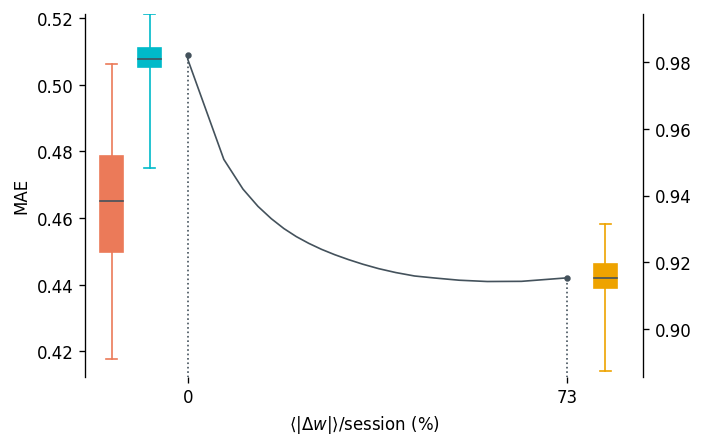

In [6]:
%matplotlib inline
matplotlib.rcParams['figure.dpi']=120

def constrained_plot(animal,sessions,predict):
    results,shuffle = do_parallel_constrained_analysis(animal,sessions,predict)

    r2    = array(list(zip(*results)))
    mae   = array([[r['MERR'] for r in rr] for rr in r2])
    maw   = array([[r['MAW' ] for r in rr] for rr in r2])
    madw  = array([[r['MADW'] for r in rr] for rr in r2])
    dwpct = median(madw,axis=1)/median(maw,axis=1)*100
    mmae  = median(mae,axis=1)
    
    s2     = array(list(zip(*shuffle)))
    smae   = array([[r['MERR'] for r in rr] for rr in s2])
    smaw   = array([[r['MAW' ] for r in rr] for rr in s2])
    smadw  = array([[r['MADW'] for r in rr] for rr in s2])
    sdwpct = median(smadw,axis=1)/median(smaw,axis=1)*100
    smmae  = median(smae,axis=1)
    
    # Draw |e| vs Δw plot, with endpoints and dashed lines to axis
    lw=1
    plot(dwpct,mmae,color=BLACK,lw=lw)
    plot([dwpct[0]]*2,[0,mmae[0]],color=BLACK,linestyle=':',lw=lw)
    plot([dwpct[-1]]*2,[0,mmae[-1]],color=BLACK,linestyle=':',lw=lw)
    scatter([dwpct[0],dwpct[-1]],[mmae[0],mmae[-1]],marker='o',s=8,color=BLACK)

    scale = np.max(dwpct)/100
    
    # Draw concatenated error box
    colored_boxplot([mae[-2,:]],[-10*scale],TURQUOISE,widths=6*scale,zorder=100,linewidth=1)

    # Draw same-day error box
    x2 = np.max(dwpct)+10*scale
    colored_boxplot([mae[1,:]],[x2],OCHRE,widths=6*scale,zorder=100,linewidth=1)
    
    simpleraxis()
    xlabel(r'$\left<|\Delta w|\right>$/session (%)')
    ylabel('MAE')
    xlim(-27*scale,x2+10*scale)
    
    shuffled = smae[-2,:]
    span1   = np.max(shuffled) -np.min(shuffled)
    scenter = (np.max(shuffled)+np.min(shuffled))*0.5
    miny    = np.min(mae)
    maxy    = np.max(mae)
    span2   = maxy-miny
    ycenter = (maxy+miny)*0.5
    yl = array([min(miny,ycenter-span1/2),max(maxy,ycenter+span1/2)])
    ylim(*yl)
    
    # Draw shuffle concatenated error box
    colored_boxplot([shuffled-scenter+ycenter],[-20*scale],RUST,widths=6*scale,zorder=100,linewidth=1)

    #xt = [0,px,np.max(dwpct)]
    xt = [0,np.max(dwpct)]
    xticks(xt,['%d'%i for i in xt])

    axa = gca()
    axb = axa.twinx()
    
    axb.tick_params(axis='y')
    axb.set_ylim(yl+scenter-ycenter)
    axb.spines['top'].set_visible(False)
    axb.spines['bottom'].set_visible(False)
    axb.spines['left'].set_visible(False)
    
    sca(axa)

constrained_plot(4,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],1)


In [ ]:

figure(figsize=(5.5,5))

ax1 = subplot2grid((3,2),(0,0))
ax2 = subplot2grid((3,2),(1,0))
ax3 = subplot2grid((3,2),(2,0))
ax4 = subplot2grid((3,2),(0,1))
ax5 = subplot2grid((3,2),(1,1))
ax6 = subplot2grid((3,2),(2,1))

animal = 3
sessions = [13, 14, 15, 16, 17, 18, 19]
print(len(sessions))
print(len(get_units_in_common(animal,sessions)[0]))

sca(ax1)
constrained_plot(animal,sessions,1)
xlabel('')
sca(ax2)
constrained_plot(animal,sessions,3)
xlabel('')
sca(ax3)
constrained_plot(animal,sessions,4)

animal = 4
sessions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#sessions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

print(len(sessions))
print(len(get_units_in_common(4,sessions)[0]))

sca(ax4)
constrained_plot(animal,sessions,1)
xlabel('')
ylabel('')
sca(ax5)
constrained_plot(animal,sessions,3)
xlabel('')
ylabel('')
sca(ax6)
constrained_plot(animal,sessions,4)
ylabel('')

subplots_adjust(hspace=0.65,wspace=0.65)

# Add text in figure coordinates
positions = array([a.get_position().ymax for a in (ax4,ax2,ax3)])+0.0125
labelx = (ax3.get_position().xmax + ax6.get_position().xmin)*0.5
for i,predict in enumerate([1,3,4]):
    plt.figtext(labelx, 
                positions[i],
                '%s (%s)'%(kininfo[predict]['name'],kininfo[predict]['units']), 
                ha='center', 
                va='bottom')

savefigure('constrained_swwep_figure_3')

7
146
10
146



# U tests

In [ ]:
to_test = [
    (3,[13, 14, 15, 16, 17, 18, 19]),
    #(4,[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),
    (4,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
]

for animal,sessions in to_test:
    for predict in [1,3,4]:
        results,shuffle = do_parallel_constrained_analysis(animal,sessions,predict)
        r2  = array(list(zip(*results)))
        mae = array([[r['MERR'] for r in rr] for rr in r2])
        pv  = scipy.stats.mannwhitneyu(mae[1,:],mae[-2,:]).pvalue
        pvs.append(pv)
        print(animal,session,'%6.3e'%pv)